# 3 Qubit Mediated CZ Gate

In [155]:
import numpy as np
import matplotlib.pyplot as plt
import qctrlvisualizer as qv
import boulderopal as bo

#bo.cloud.set_verbosity('QUIET')
plt.style.use(qv.get_qctrl_style())

controls_for_plots = lambda opt: {
    '$\\Delta$': opt['output']['delta'],
    '$\\Omega$': opt['output']['omega'],
    '$\\Phi$': opt['output']['phi']
}

# Set parameters.
omega_max = 5 * 2 * np.pi * 1e6 # rad/s
delta_max = omega_max * 0.4
tau = 2 * 1e-6 # s

# Define the control.
segment_count = 2
sample_times = np.linspace(0, 1, 500)

# Define basis.
basis_labels = ['0', '1', 'r', '11', 'W', '111', 'W2', 'r1r', '1r1']

# Components for the drive operator.
drive_operator = np.zeros((9, 9))
drive_operator[1, 2] = 1
drive_operator[3, 4] = np.sqrt(2)
drive_operator[5,6] = np.sqrt(2)
drive_operator[5, 8] = 1
drive_operator[6,7] = np.sqrt(2)

# Components for the detuning operator.
detuning_operator = np.diag([0, 0, -1, 0, -1, 0, -1 , -2, -1])

# Components for the CCZ operator.
cz_0 = np.diag([1, 0, 0, 0, 0, 0, 0, 0, 0])
cz_1 = np.diag([0, 1, 0, 0, 0, 0, 0, 0, 0])
cz_11 = np.diag([0, 0, 0, 1, 0, 0, 0, 0, 0])
cz_111 = np.diag([0, 0, 0, 0, 0, 1, 0, 0, 0])

In [156]:
graph = bo.Graph()

# Real piece-wise constant signal representing the detuning.
delta = (
    graph.real_optimizable_pwc_signal(
        segment_count = 1, 
        duration = 1, 
        minimum = 0,
        maximum = delta_max,
        name = 'delta'
    )
)

duration_op = graph.optimizable_scalar(lower_bound=0.2e-6, upper_bound=tau, name="optimizable_duration")

# Real piece-wise constant signal representing the Rabi amplitude.
omega = (
    graph.real_optimizable_pwc_signal(
        segment_count = 1, 
        duration = 1, 
        minimum = 0,
        maximum = omega_max,
        name = 'omega'
    )
)

# Real piece-wise constant signal representing the Rabi phase.
phi = (
    graph.real_optimizable_pwc_signal(
        segment_count = segment_count, 
        duration = 1, 
        minimum = 0,
        maximum = 2 * np.pi, 
        name = 'phi'
    )
)

# Real scalar signal representing the single qubit phase.
psi = (
    graph.optimizable_scalar(
        lower_bound = 0,
        upper_bound = 2 * np.pi, 
        name = 'psi'
    )
)

# Define the Hamiltonian.
hamiltonian = (
    graph.hermitian_part(omega * graph.exp(1j * phi) * drive_operator) + 
    delta * detuning_operator
) * duration_op

# Define the target operator.
target = (
    graph.target(
        operator = (
            cz_0 +
            graph.exp(1j * psi) * cz_1 + 
            graph.exp(1j * (2 * psi)) * cz_11 + 
            graph.exp(1j * (3 * psi + np.pi)) * cz_111
        )
    )
)

# Unitary time evolution.
unitary = (
    graph.time_evolution_operators_pwc(
        hamiltonian = hamiltonian, 
        sample_times = sample_times, 
        name = 'unitary'
    )
)

# Infidelity.
infidelity = (
    graph.infidelity_pwc(
        hamiltonian = hamiltonian,
        target = target,
        name = 'infidelity'
    )
)

# Cost function.
cost_function = (
    graph.sum(
        infidelity
    )
)
cost_function.name = 'cost_function'

In [157]:
result = (
    bo.run_optimization(
        graph = graph,
        cost_node_name = 'cost_function',
        output_node_names = [
            'omega', 
            'delta', 
            'phi', 
            'psi', 
            'unitary',
            'infidelity',
            'optimizable_duration'
        ]
    )
)

Your task (action_id="1980383") is queued.
Your task (action_id="1980383") has started.
Your task (action_id="1980383") has completed.


In [158]:
eta = result['output']['delta']['values'][0] / result['output']['omega']['values'][0]
xi = np.abs(result['output']['phi']['values'][0] - result['output']['phi']['values'][1])
duration = result['output']['optimizable_duration']['value']
omegatau = result['output']['omega']['values'][0] * duration / 2

print(f"Duration: {duration}")
print(f"Infidelity: {result['output']['infidelity']['value']:.3e}")
print(f"Gate time: {omegatau}")
print(f"Ratio of detuning and Rabi frequncy: {eta}")
print(f"Phase jump: {xi}")
print(f"Equivalent phase jump: {2 * np.pi - xi}")
print(f"Single qubit phase: {result['output']['psi']['value']}")

Duration: 1.0490864394960973e-06
Infidelity: 2.896e-01
Gate time: 8.164760940835206
Ratio of detuning and Rabi frequncy: 0.41848971623799924
Phase jump: 4.8974304084234515
Equivalent phase jump: 1.3857548987561348
Single qubit phase: 1.1591978151290416


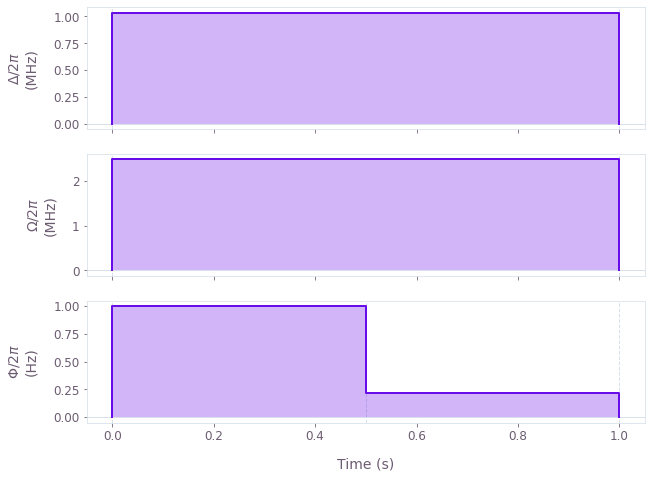

In [159]:
qv.plot_controls(controls_for_plots(result))

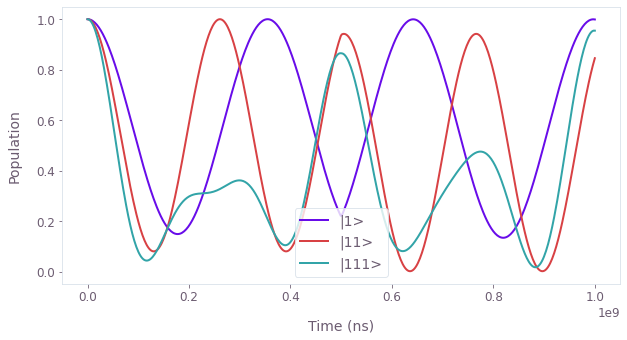

In [160]:
u = result['output']['unitary']['value']

psi1 = np.array([0,1,0,0,0,0,0,0,0])
out1 = np.abs(np.transpose(psi1) @ u @ psi1)**2
psi11 = np.array([0,0,0,1,0,0,0,0,0])
out11 = np.abs(np.transpose(psi11) @ u @ psi11)**2
psi111 = np.array([0,0,0,0,0,1,0,0,0])
out111 = np.abs(np.transpose(psi111) @ u @ psi111)**2

plt.plot(1e9 * sample_times, out1)
plt.plot(1e9 * sample_times, out11)
plt.plot(1e9 * sample_times, out111)
plt.xlabel('Time (ns)')
plt.ylabel('Population')
plt.legend(['|1>', '|11>', '|111>'])